In [69]:
# Imports

import pandas as pd
import os
from plotnine import *
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from darts.models.forecasting import auto_arima
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from darts.utils.statistics import plot_residuals_analysis

%matplotlib inline

In [ ]:
# # Reading and Saving Data
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
# airpollution = pd.read_csv(url, index_col='No')
# airpollution.to_csv('data/airpollution.csv')

In [2]:
# Reading Data

airpollution = pd.read_csv('data/airpollution.csv')
airpollution['time_of_day'] = pd.to_datetime(airpollution[['year','month', 'day','hour']]).dt.strftime('%d/%m/%y %H:%M')
airpollution.drop(columns='No', axis=1, inplace=True)
airpollution

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time_of_day
0,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,01/01/10 00:00
1,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,01/01/10 01:00
2,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,01/01/10 02:00
3,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,01/01/10 03:00
4,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,01/01/10 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,31/12/14 19:00
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,31/12/14 20:00
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,31/12/14 21:00
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,31/12/14 22:00


In [3]:
# Null Values Check

airpollution.isna().sum()

year              0
month             0
day               0
hour              0
pm2.5          2067
DEWP              0
TEMP              0
PRES              0
cbwd              0
Iws               0
Is                0
Ir                0
time_of_day       0
dtype: int64

In [4]:
# Index of Missing Values

airpollution[airpollution['pm2.5'].isna()].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            43283, 43544, 43545, 43546, 43547, 43548, 43549, 43550, 43551,
            43552],
           dtype='int64', length=2067)

In [5]:
# Summary

airpollution.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


/Users/s1b0ert/opt/anaconda3/envs/learning/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2067 rows containing missing values.


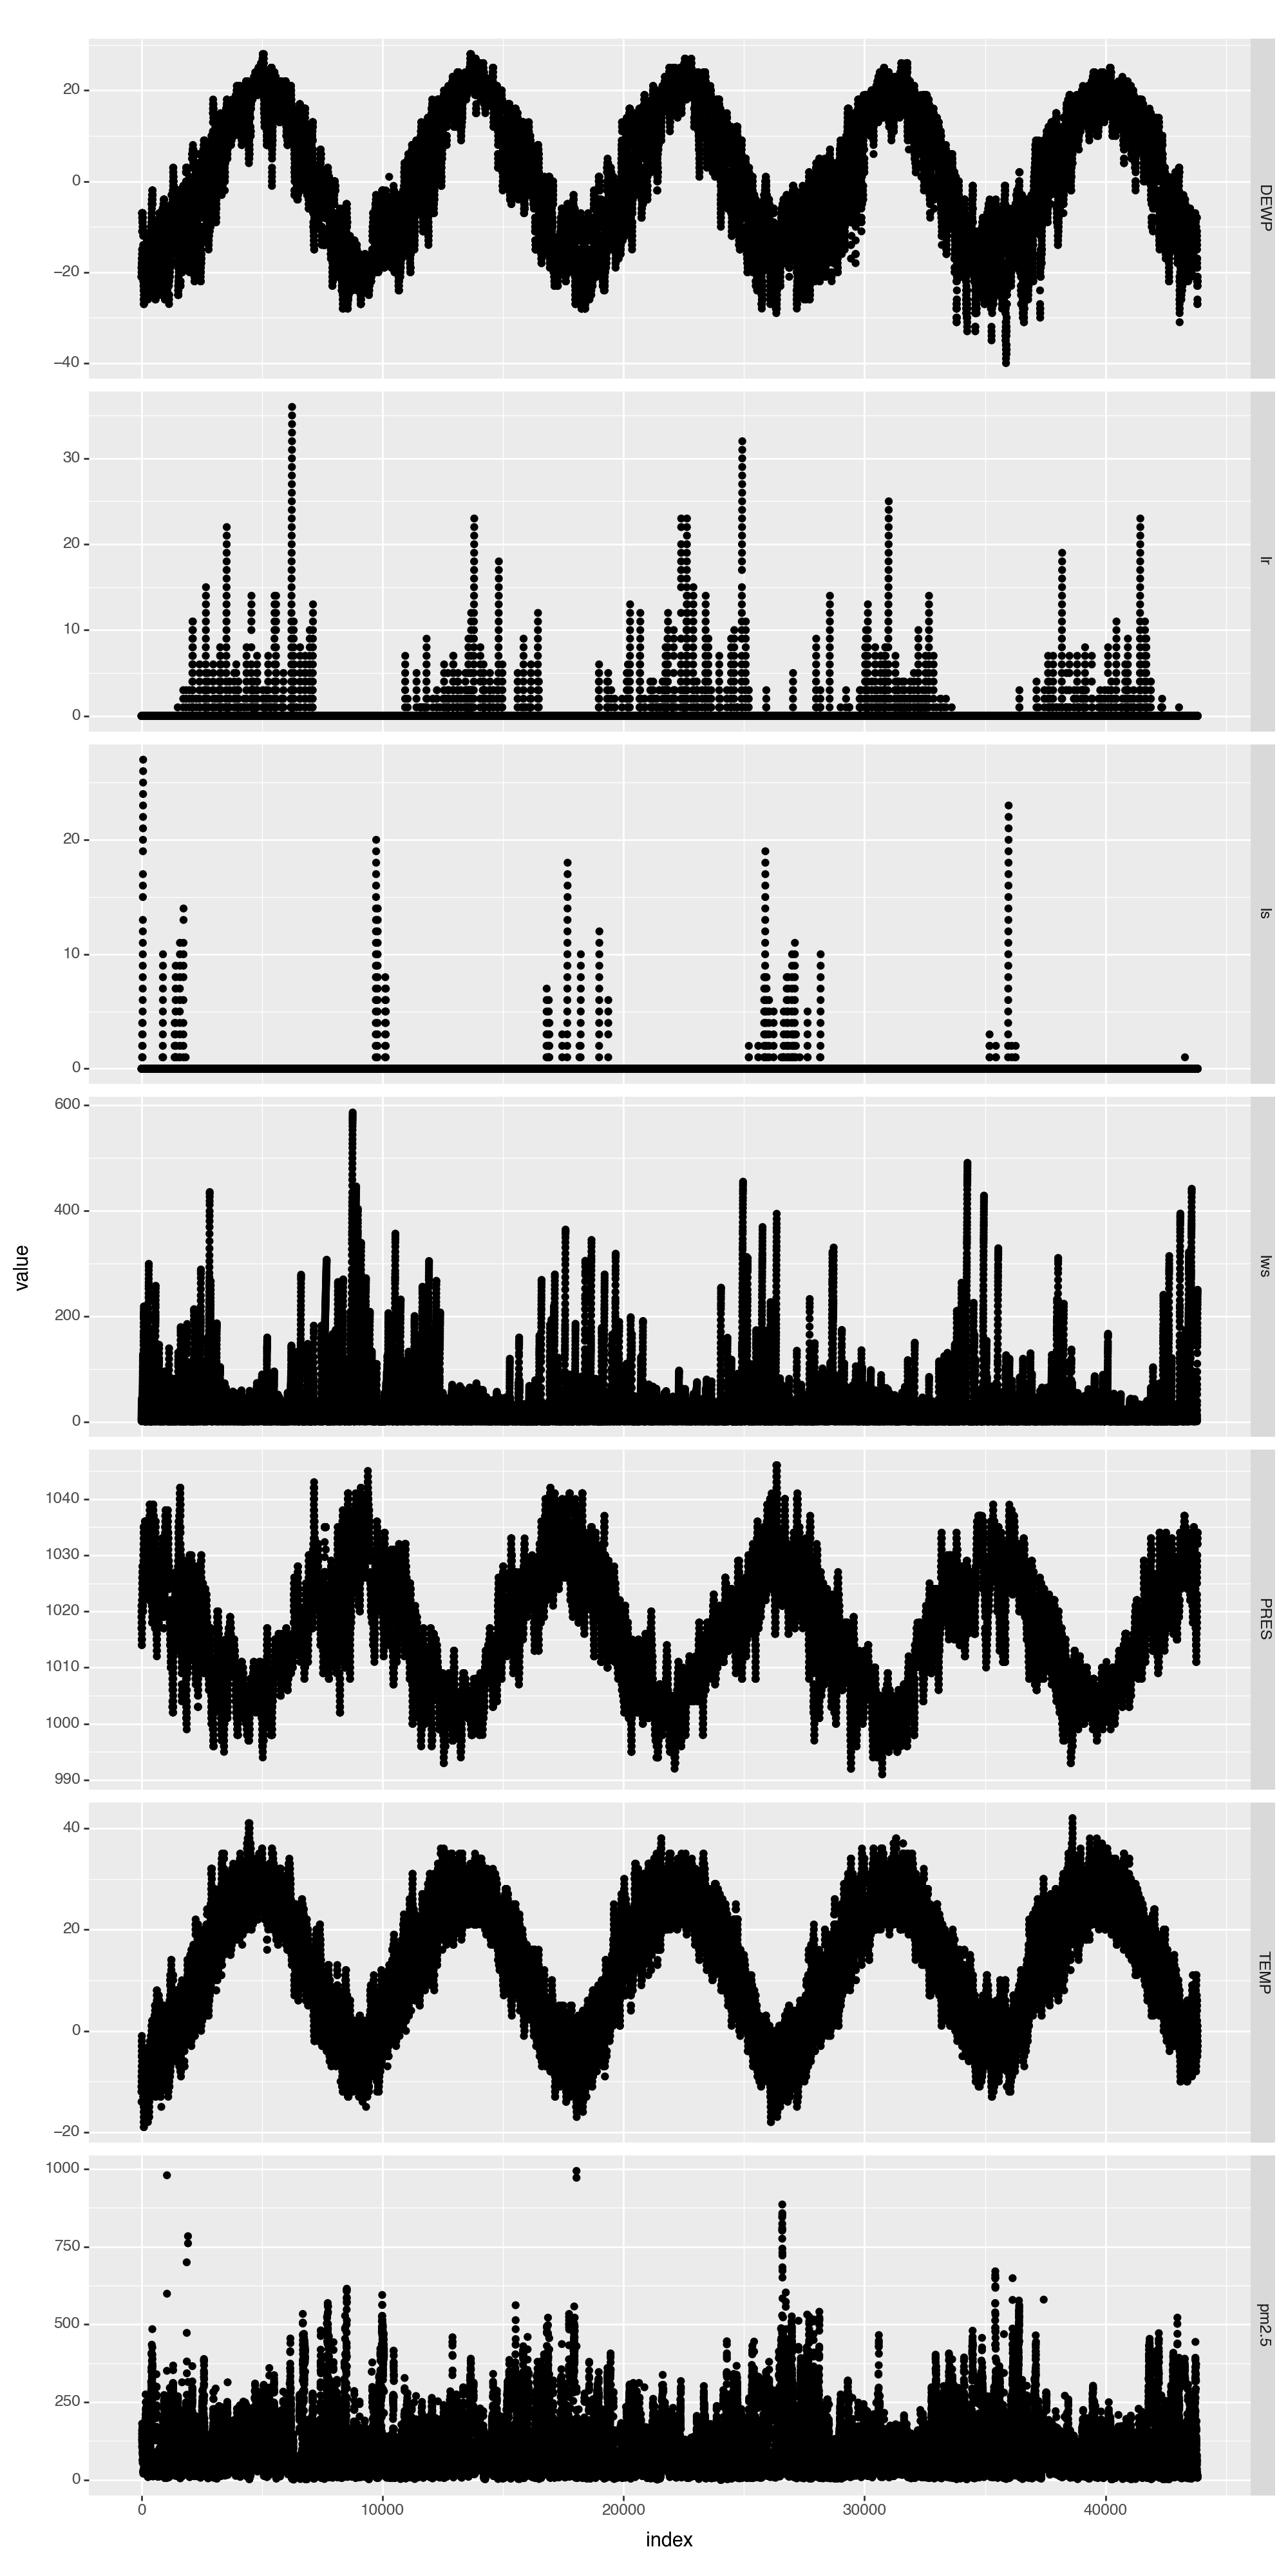

<Figure Size: (1000 x 2000)>

In [6]:
# Plot Variables

cols = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
plot_data = airpollution.copy(deep=False)
plot_data['index'] = plot_data.index
plot_data = plot_data.melt(id_vars=['index'], value_vars=cols)
plot = (ggplot(plot_data) +
        geom_point(aes(x='index', y='value')) +
        facet_grid('variable ~ .', scales='free') +
        theme(figure_size=(10, 20))
       )
plot       

/var/folders/0d/mfh0tdt50zs740_mms5qxj280000gq/T/ipykernel_52265/3860214380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/s1b0ert/opt/anaconda3/envs/learning/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 92 rows containing missing values.


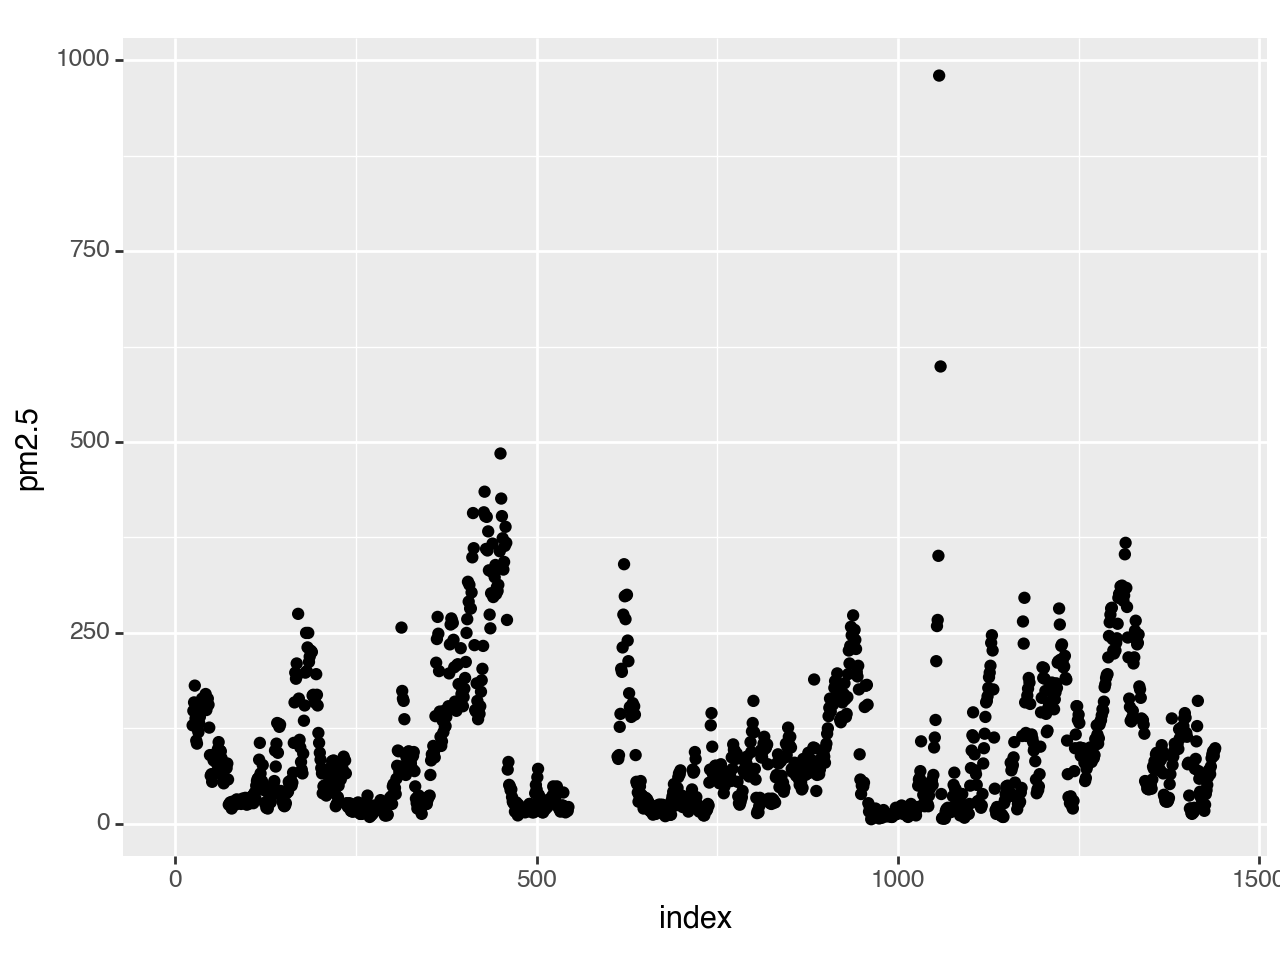

<Figure Size: (640 x 480)>

In [14]:
# Visualize Pollution for Two Months

plot_data = airpollution[:24*60]
plot_data['index'] = plot_data.index
plot = (ggplot(plot_data) +
        geom_point(aes(x='index', y='pm2.5'))
       )
plot    

In [15]:
# Impute Values - Fill with Previous Values

imputed_data = airpollution.copy(deep=False)
imputed_data['pm2.5'].ffill(inplace=True)
imputed_data.dropna(axis=0, inplace=True)
imputed_data


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time_of_day
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,02/01/10 00:00
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,02/01/10 01:00
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,02/01/10 02:00
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,02/01/10 03:00
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,02/01/10 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,31/12/14 19:00
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,31/12/14 20:00
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,31/12/14 21:00
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,31/12/14 22:00


In [16]:
# One Hot Encoding Wind Direction (cbwd)

encoded_data = imputed_data.copy(deep=False)
encoded_data = pd.concat([encoded_data, pd.get_dummies(encoded_data['cbwd'])], axis=1)
encoded_data

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time_of_day,NE,NW,SE,cv
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,02/01/10 00:00,0,0,1,0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,02/01/10 01:00,0,0,1,0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,02/01/10 02:00,0,0,1,0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,02/01/10 03:00,0,0,1,0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,02/01/10 04:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,31/12/14 19:00,0,1,0,0
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,31/12/14 20:00,0,1,0,0
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,31/12/14 21:00,0,1,0,0
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,31/12/14 22:00,0,1,0,0


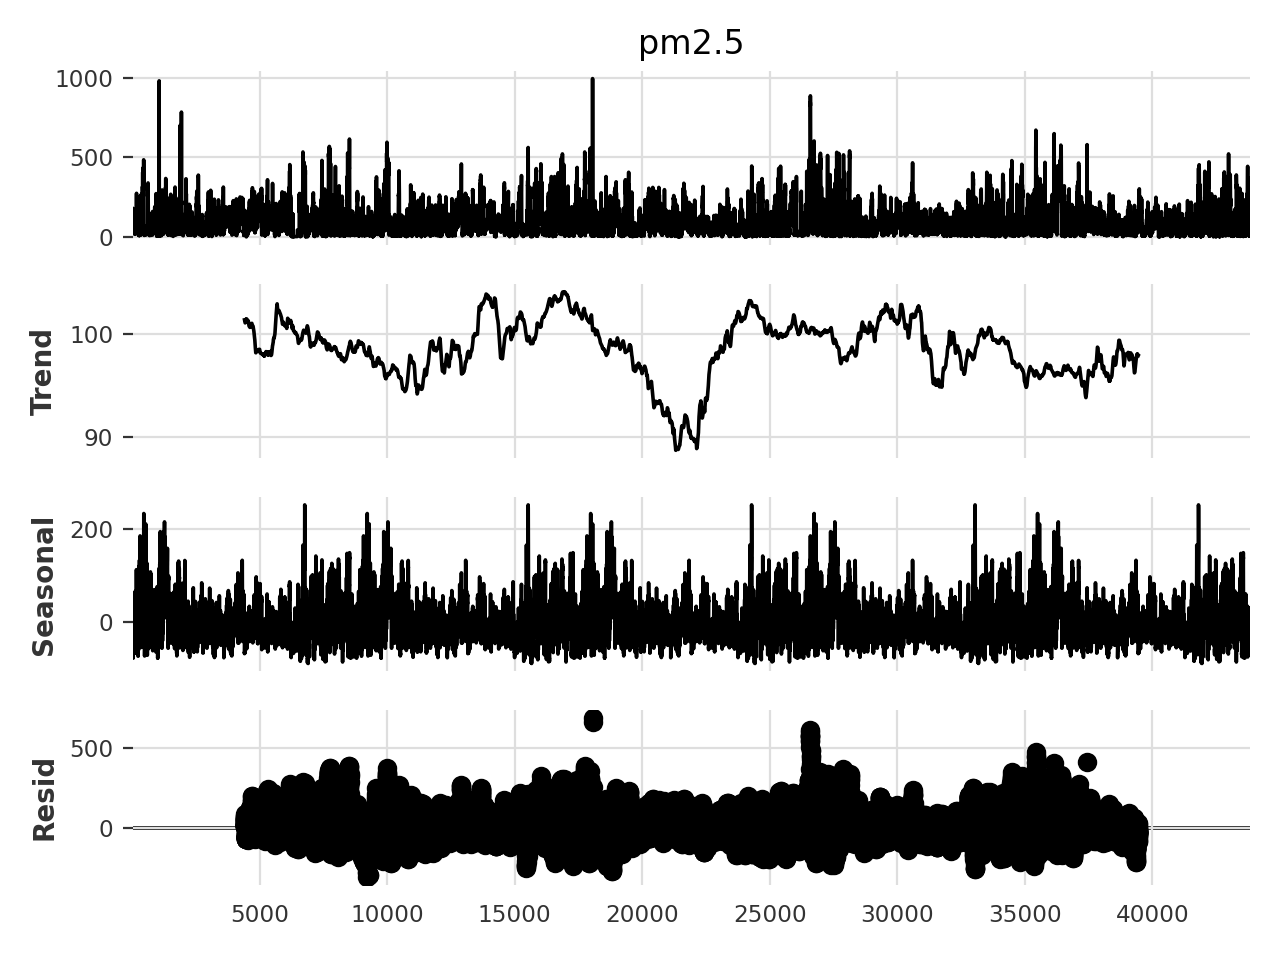

In [17]:
# Decomposition of Timeseries - Period Yearly

result = seasonal_decompose(encoded_data['pm2.5'], model='additive', period=365*24)
result.plot();

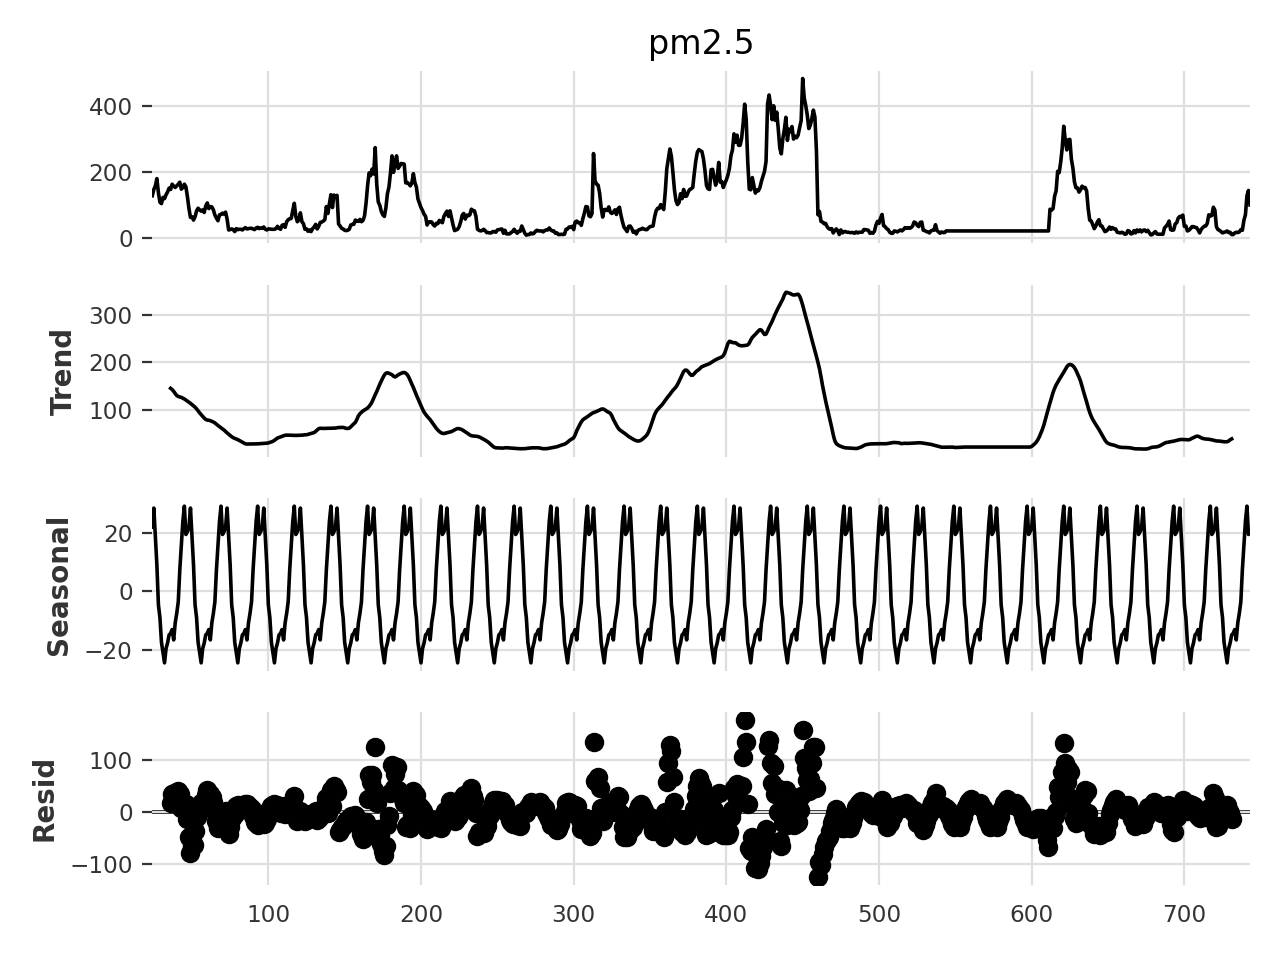

In [28]:
# Taking One Month of Data and Check Seasonality

result = seasonal_decompose(encoded_data[:24*30]['pm2.5'], model='additive', period=24)
result.plot();

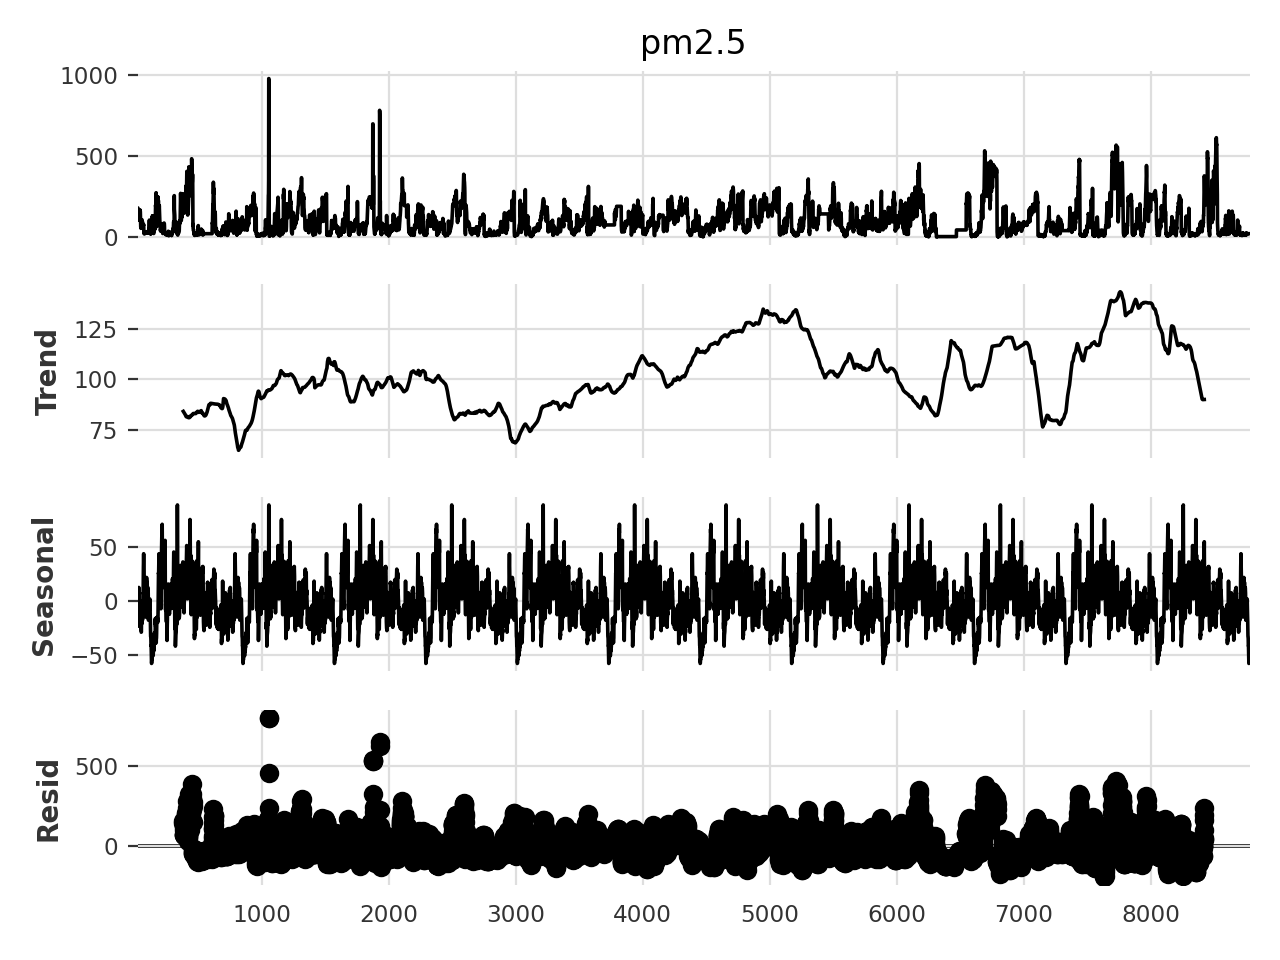

In [29]:
# Taking One Year Data and Check Monthly Seasonality

result = seasonal_decompose(encoded_data[:24*365]['pm2.5'], model='additive', period=24*30)
result.plot();

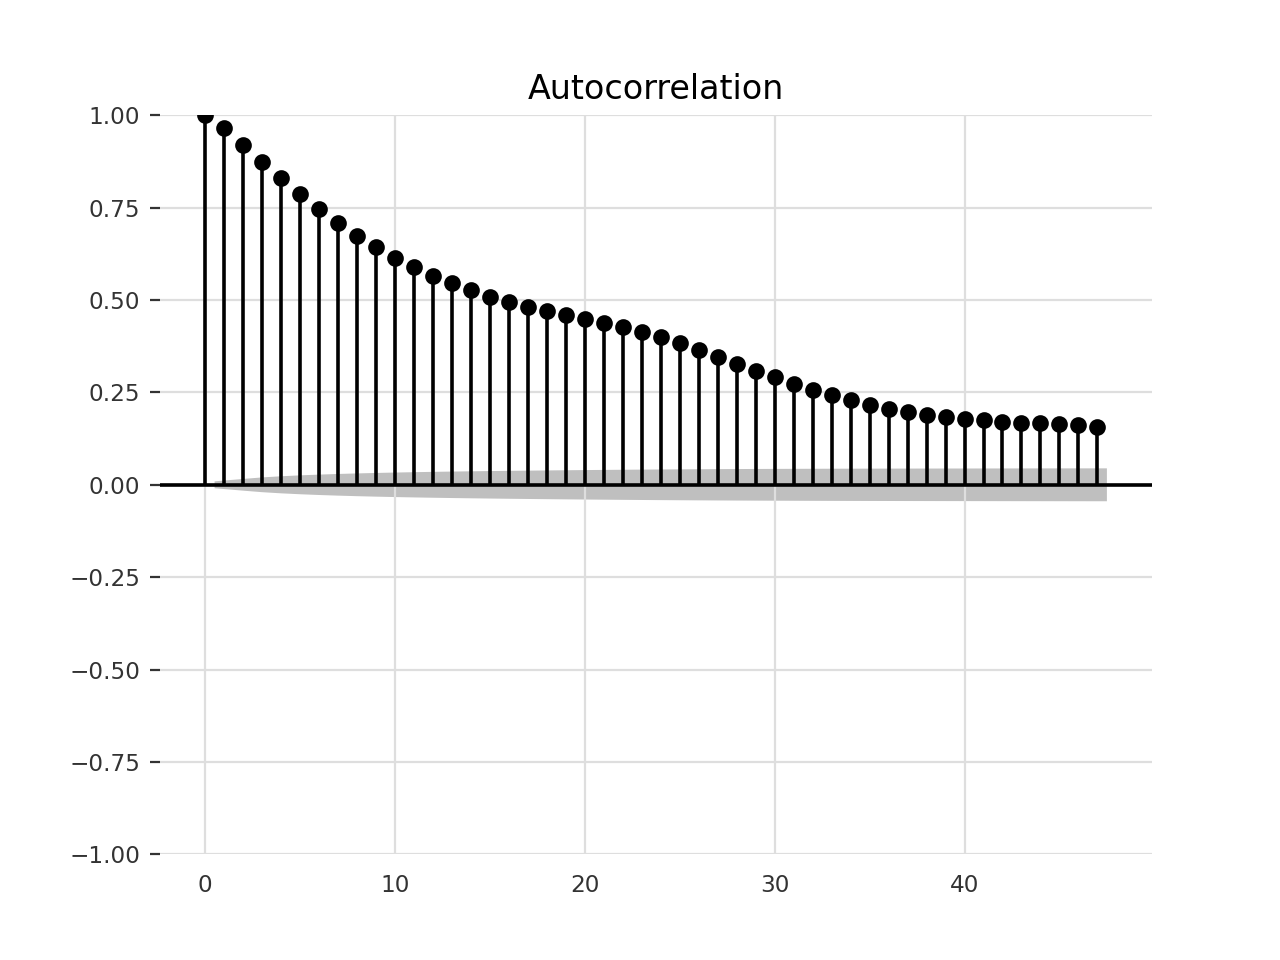

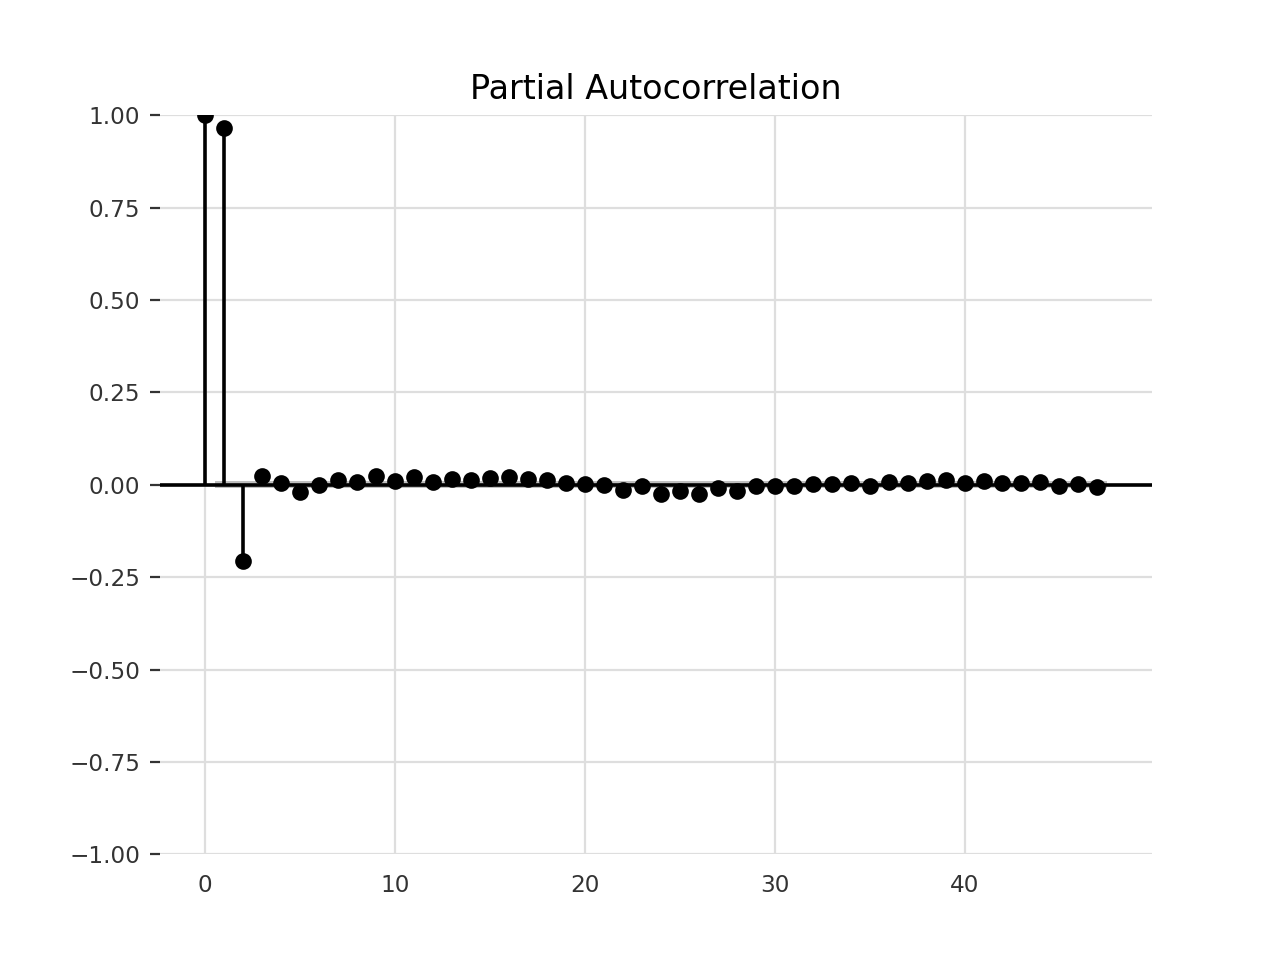

In [30]:
# PACF & ACF

plot_acf(encoded_data['pm2.5']);
plot_pacf(encoded_data['pm2.5']);

In [31]:
# Check Stationarity

adfuller_result = adfuller(encoded_data['pm2.5'])
print(f'ADF Stat: {adfuller_result[0]}')
print(f'P Value: {adfuller_result[1]}') 

ADF Stat: -21.21155784101682
P Value: 0.0


In [32]:
# Converting Series to Darts Timeseries

value_cols = ['month', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'NE', 'NW', 'SE', 'cv']
darts_data = TimeSeries.from_dataframe(encoded_data, time_col='time_of_day', value_cols=value_cols)
darts_data

<TimeSeries (DataArray) (time_of_day: 43800, component: 13, sample: 1)>
array([[[ 2.],
        [ 0.],
        [65.],
        ...,
        [ 0.],
        [ 1.],
        [ 0.]],

       [[ 2.],
        [ 1.],
        [70.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 2.],
        [ 2.],
        [67.],
        ...,
...
        ...,
        [ 1.],
        [ 0.],
        [ 0.]],

       [[12.],
        [22.],
        [ 8.],
        ...,
        [ 1.],
        [ 0.],
        [ 0.]],

       [[12.],
        [23.],
        [12.],
        ...,
        [ 1.],
        [ 0.],
        [ 0.]]])
Coordinates:
  * time_of_day  (time_of_day) datetime64[ns] 2010-01-02 ... 2014-12-31T23:00:00
  * component    (component) object 'month' 'hour' 'pm2.5' ... 'NW' 'SE' 'cv'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Size of training data: 43464
Size of test data: 168
Size of valid data: 168


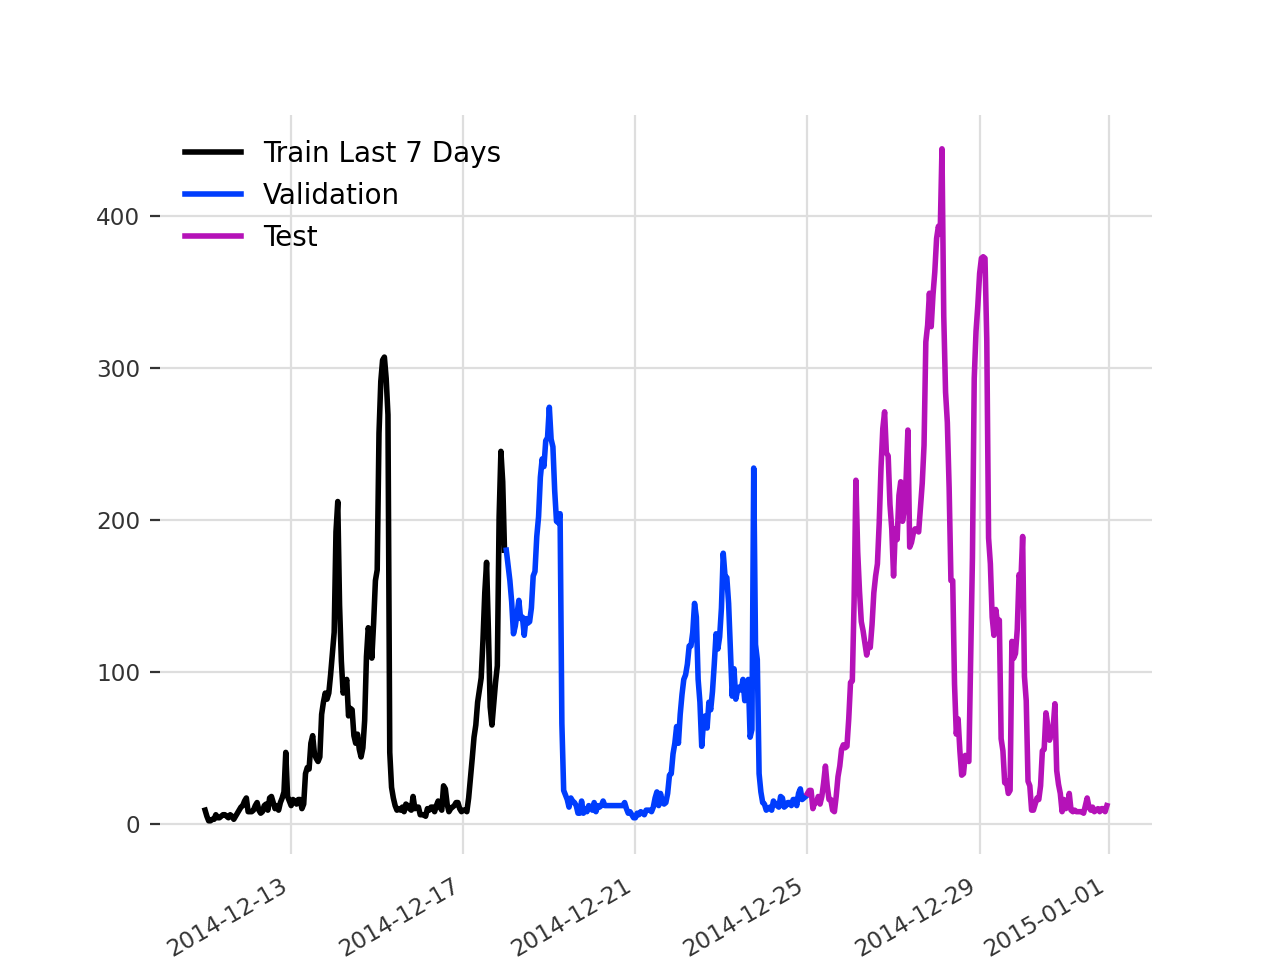

In [90]:
# Train, Test & Validation Data

FORECAST_HORIZON = 7*24

staging_train, test_data = darts_data[:-FORECAST_HORIZON], darts_data[-FORECAST_HORIZON:]
train_data, valid_data = staging_train[:-FORECAST_HORIZON], staging_train[-FORECAST_HORIZON:]
print(f'Size of training data: {len(train_data)}')
print(f'Size of test data: {len(test_data)}')
print(f'Size of valid data: {len(valid_data)}')

train_data[-24*7:]['pm2.5'].plot(label='Train Last 7 Days')
valid_data['pm2.5'].plot(label='Validation')
test_data['pm2.5'].plot(label='Test')


### Univariate - AutoArima

In [26]:
cpu_count = os.cpu_count()
cpu_count

16

In [50]:
# Train AutoArima


start_index = len(train_data)-24*180 # Use Last 6 Months of Data for Training

auto_arima_model = auto_arima.AutoARIMA(start_p=0,
                                        max_p=1,
                                        start_q=30,
                                        max_q=30,
                                        seasonal=True,
                                        d=0,
                                        stationary=True,
                                        information_criterion='aic',
                                        start_P=1,
                                        max_P=2,
                                        start_Q=1,
                                        max_Q=2,
                                        max_order=None,
                                        m=24,
                                        max_D=2,
                                        stepwise=False,
                                        random=True,
                                        n_jobs=int(cpu_count/2),
                                        random_state=123,
                                        trace=True,
                                        method='nm')
                                        
auto_arima_model.fit(series=train_data[start_index:]['pm2.5'])                                        

 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=46579.467, Time=5.35 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=47258.044, Time=23.46 sec
 ARIMA(1,0,3)(2,0,0)[24] intercept   : AIC=40969.479, Time=26.75 sec
 ARIMA(1,0,8)(2,0,1)[24] intercept   : AIC=41049.513, Time=30.45 sec
 ARIMA(1,0,5)(2,0,0)[24] intercept   : AIC=41141.690, Time=34.00 sec
 ARIMA(0,0,22)(0,0,1)[24] intercept   : AIC=42673.602, Time=38.00 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=46565.122, Time=41.84 sec
 ARIMA(1,0,22)(2,0,1)[24] intercept   : AIC=41441.192, Time=50.74 sec
 ARIMA(1,0,10)(0,0,2)[24] intercept   : AIC=40778.069, Time=77.12 sec
 ARIMA(1,0,4)(2,0,2)[24] intercept   : AIC=40550.408, Time=55.49 sec

Best model:  ARIMA(1,0,4)(2,0,2)[24] intercept
Total fit time: 443.095 seconds


AutoARIMA(add_encoders=None, start_p=0, max_p=1, start_q=30, max_q=30, seasonal=True, d=0, stationary=True, information_criterion=aic, start_P=1, max_P=2, start_Q=1, max_Q=2, max_order=None, m=24, max_D=2, stepwise=False, random=True, n_jobs=8, random_state=123, trace=True, method=nm)

In [52]:
# Save Model

path = 'models/airpollution_autoarima.pkl'
auto_arima_model.save(path)

MAPE: 861.895
RMSE: 137.715


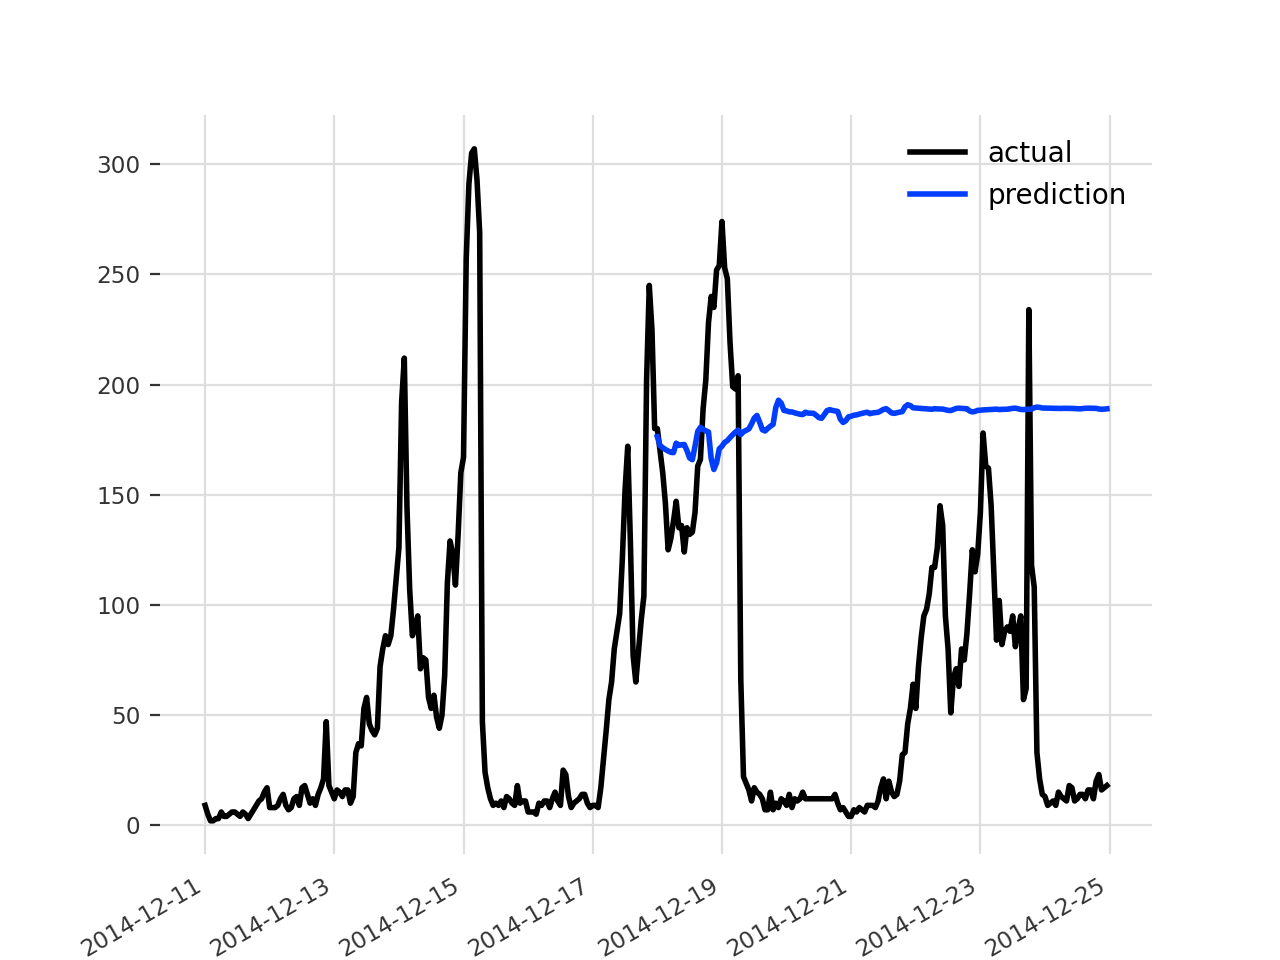

In [63]:
# Predict

val_prediction = auto_arima_model.predict(n=FORECAST_HORIZON)

start_index = len(staging_train) - 24*14
staging_train['pm2.5'][start_index:].plot(label='actual')
val_prediction.plot(label='prediction')
mape_ = round(mape(valid_data['pm2.5'], val_prediction), 3)
print(f'MAPE: {mape_}')

rmse_ = round(rmse(valid_data['pm2.5'], val_prediction), 3)
print(f'RMSE: {rmse_}')

### Univariate - NBeats with Scaling

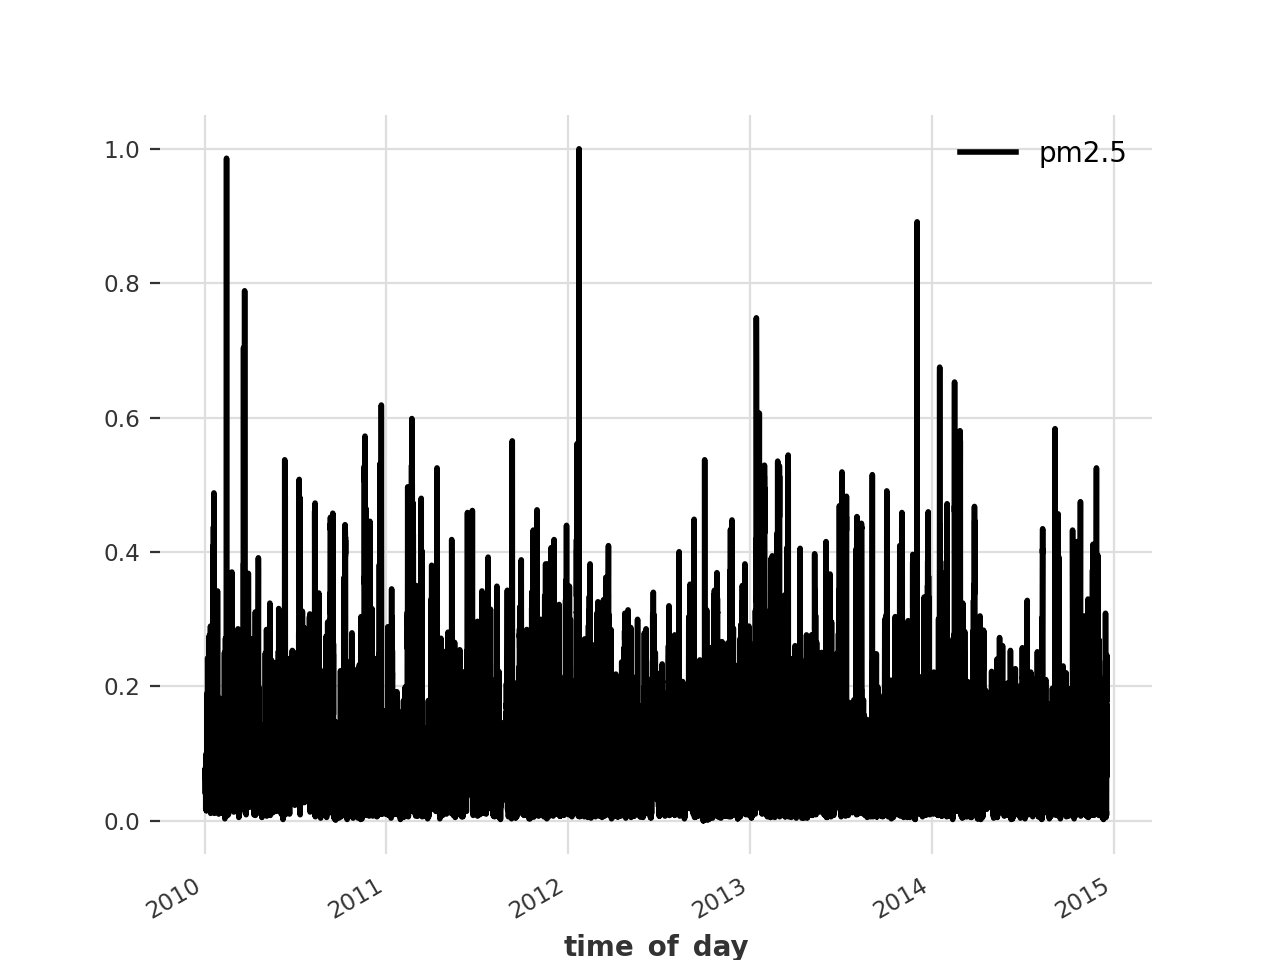

In [74]:
# Scaling Darts TS

covs = ['month', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'NE', 'NW', 'SE', 'cv']
scaler_covs = Scaler()
scaled_train_covs = scaler_covs.fit_transform(train_data[covs])
scaled_valid_covs = scaler_covs.transform(valid_data[covs])

scaler_target = Scaler()
scaled_train_ts = scaler_target.fit_transform(train_data['pm2.5'])
scaled_valid_ts = scaler_target.transform(valid_data['pm2.5'])

In [75]:
# Fit Model

start_index = len(scaled_train_ts) - 24*365 # Training on Last 1 Year Data
model = NBEATSModel(input_chunk_length=24*7,
                    output_chunk_length=24,
                    random_state=42)

model.fit(scaled_train_ts[start_index:],
          epochs=50,
          verbose=True
          )                    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 268/268 [01:11<00:00,  3.76it/s, train_loss=0.000368]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 268/268 [01:11<00:00,  3.76it/s, train_loss=0.000368]


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
MAPE: 760.64%
RMSE: 160.59%


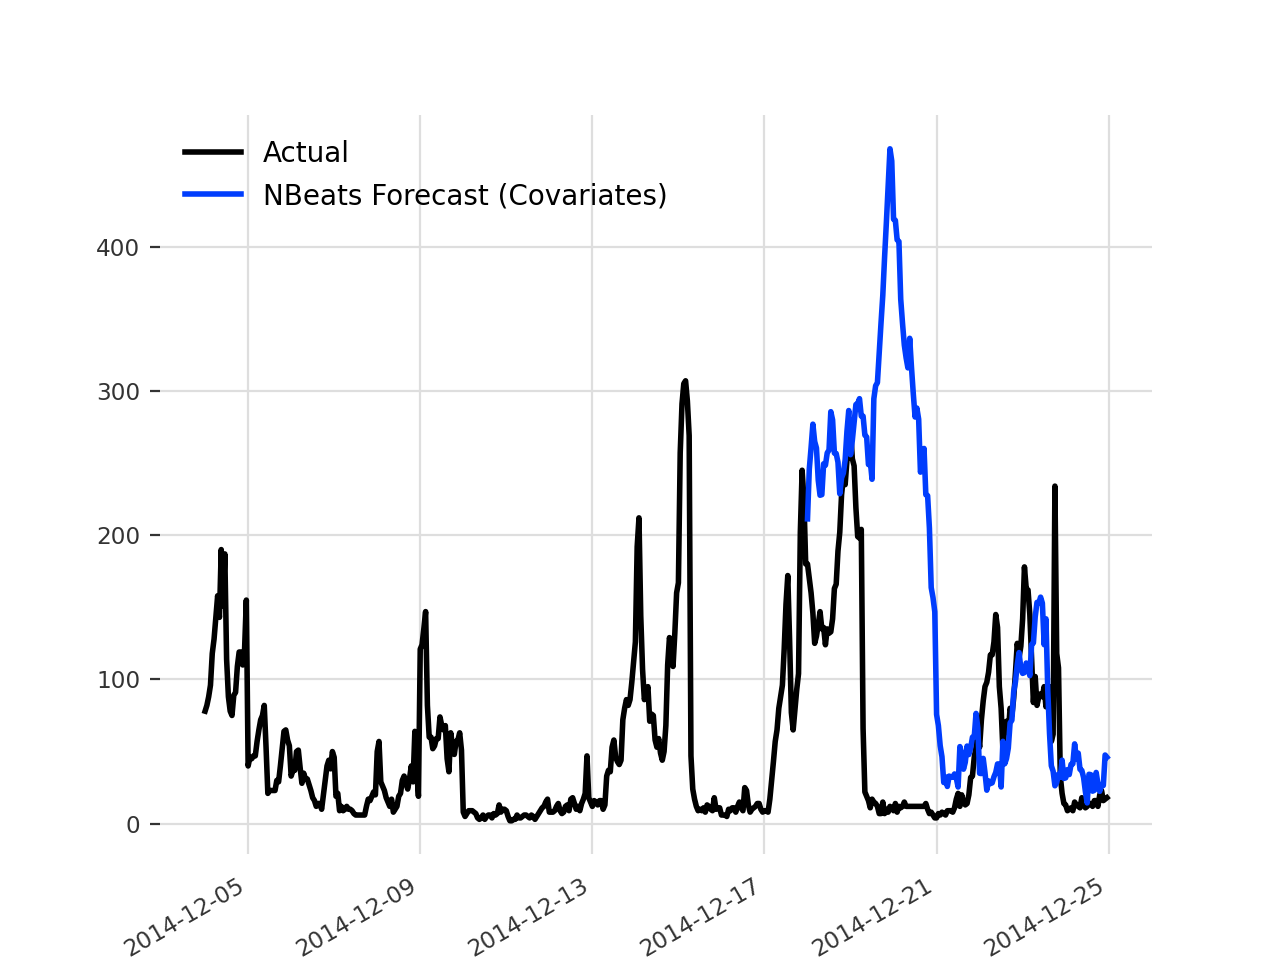

In [79]:
# Predict

valid_pred = model.predict(series=scaled_train_ts[start_index:],
                           n=FORECAST_HORIZON) 

valid_pred = scaler_target.inverse_transform(valid_pred)

plot_start_index = len(train_data) - 24*14
staging_train[plot_start_index:]['pm2.5'].plot(label='Actual')
valid_pred.plot(label='NBeats Forecast (Covariates)')

mape_ = mape(valid_data['pm2.5'], valid_pred)
print(f'MAPE: {round(mape_, 2)}%')

rmse_ = rmse(valid_data['pm2.5'], valid_pred)
print(f'RMSE: {round(rmse_, 2)}%')

### Multivariate - NBeats 

Size of training data: 43704
Size of test data: 48
Size of valid data: 48


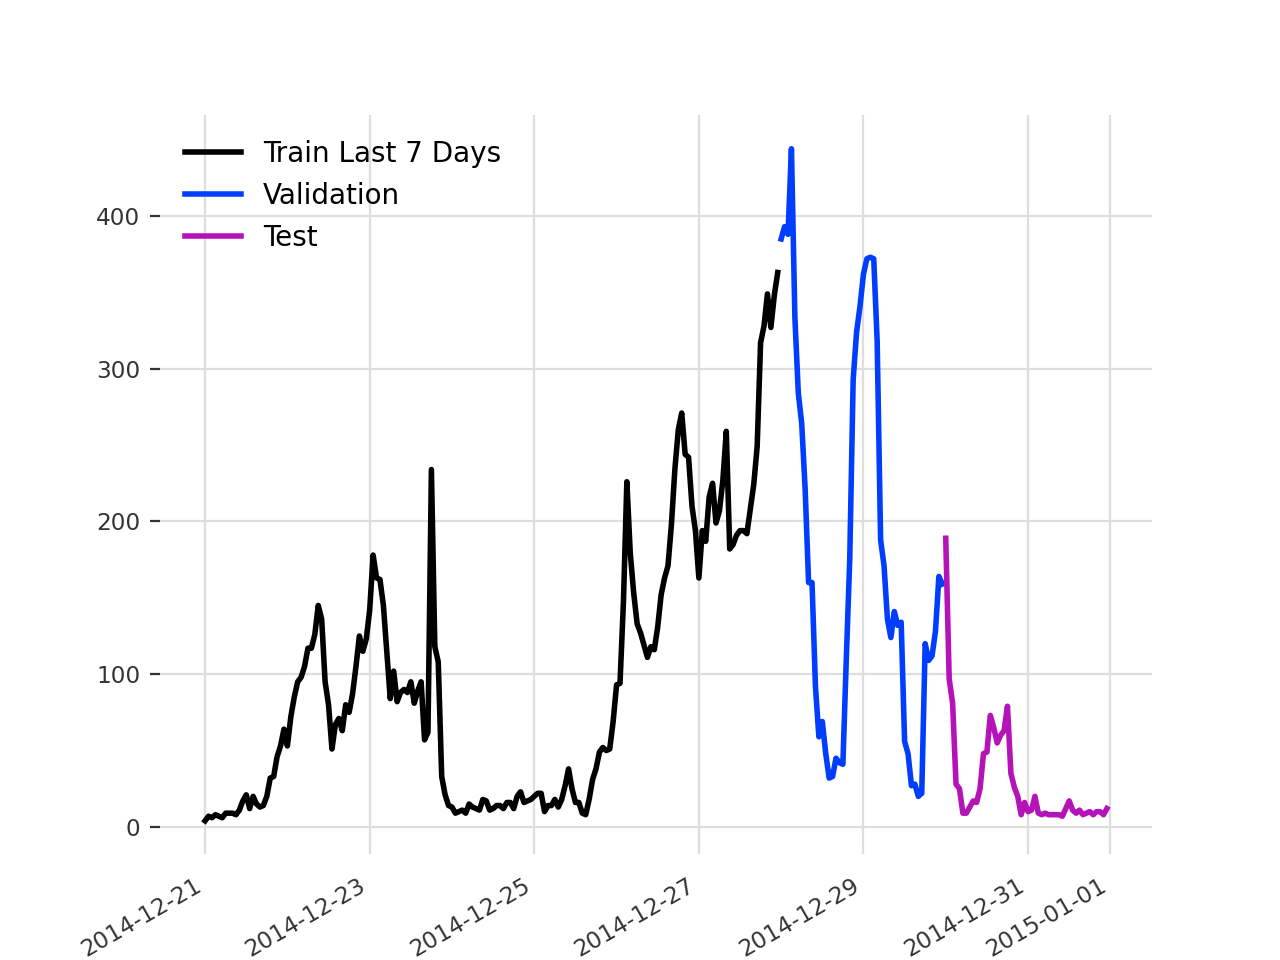

In [91]:
# Train, Test & Validation Data

FORECAST_HORIZON = 24*2

staging_train, test_data = darts_data[:-FORECAST_HORIZON], darts_data[-FORECAST_HORIZON:]
train_data, valid_data = staging_train[:-FORECAST_HORIZON], staging_train[-FORECAST_HORIZON:]
print(f'Size of training data: {len(train_data)}')
print(f'Size of test data: {len(test_data)}')
print(f'Size of valid data: {len(valid_data)}')

train_data[-24*7:]['pm2.5'].plot(label='Train Last 7 Days')
valid_data['pm2.5'].plot(label='Validation')
test_data['pm2.5'].plot(label='Test')


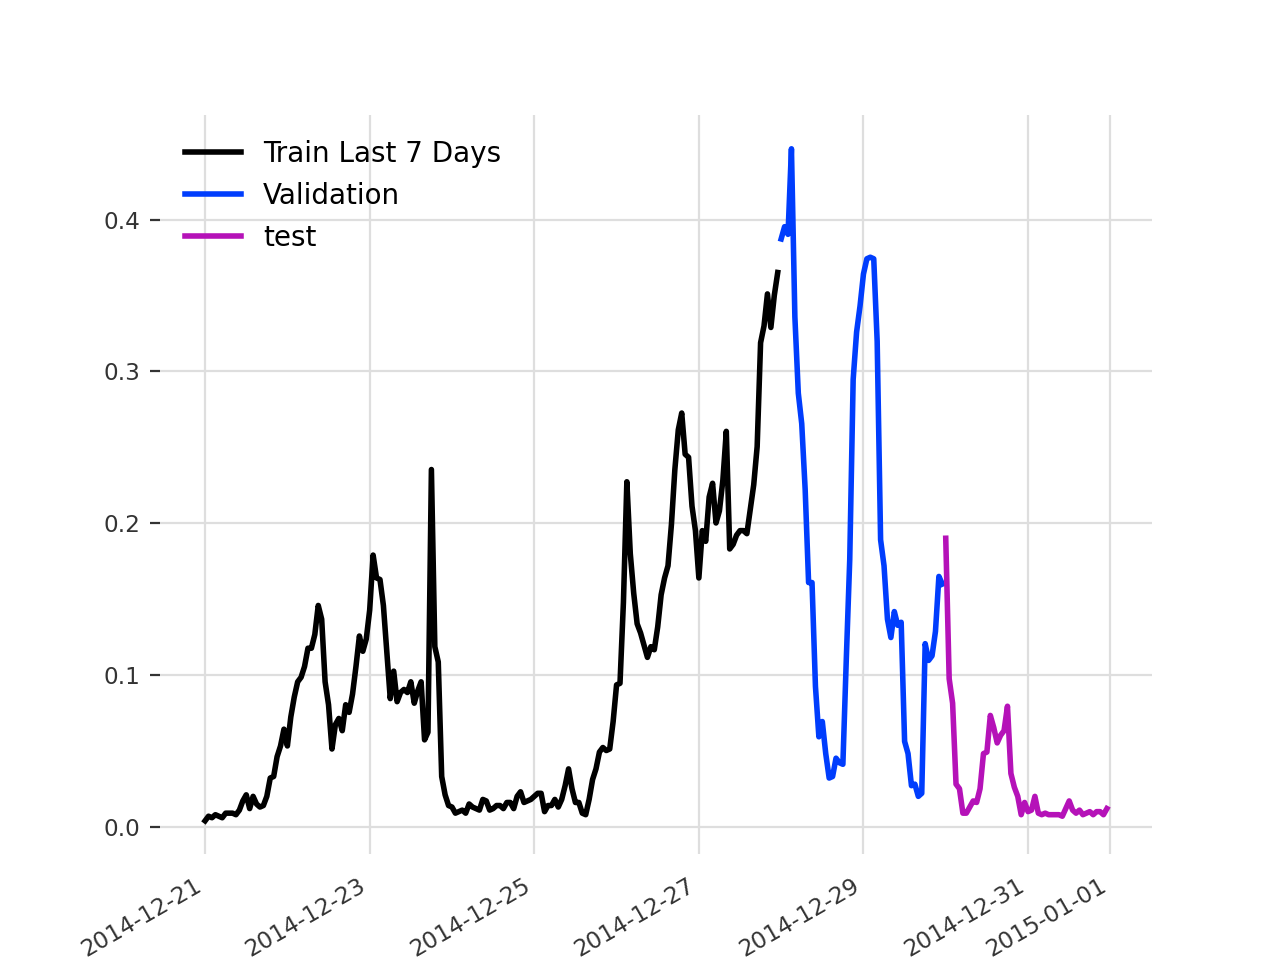

In [105]:
# Scaling Darts TS

covs = ['month', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'NE', 'NW', 'SE', 'cv']
scaler_covs = Scaler()
scaled_train_covs = scaler_covs.fit_transform(train_data[covs])
scaled_valid_covs = scaler_covs.transform(valid_data[covs])
scaled_test_covs = scaler_covs.transform(test_data[covs])

scaler_target = Scaler()
scaled_train_ts = scaler_target.fit_transform(train_data['pm2.5'])
scaled_valid_ts = scaler_target.transform(valid_data['pm2.5'])
scaled_test_ts = scaler_target.transform(test_data['pm2.5'])

scaled_train_ts[-24*7:]['pm2.5'].plot(label='Train Last 7 Days')
scaled_valid_ts['pm2.5'].plot(label='Validation')
scaled_test_ts['pm2.5'].plot(label='test')

In [97]:
# Fit

train_start_index = len(scaled_train_ts) - 24*365*2 # Training on Last 2 Year Data
model = NBEATSModel(input_chunk_length=24*14,
                    output_chunk_length=24*2,
                    random_state=42)
model.fit(scaled_train_ts[train_start_index:],
          past_covariates=scaled_train_covs[train_start_index:],
          epochs=50,
          verbose=True
          )           

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 40.5 M
---------------------------------------------------
40.4 M    Trainable params
27.5 K    Non-trainable params
40.5 M    Total params
161.803   Total estimated model params size (MB)


Epoch 49: 100%|██████████| 536/536 [07:55<00:00,  1.13it/s, train_loss=0.000352]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 536/536 [07:55<00:00,  1.13it/s, train_loss=0.000352]


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=336, output_chunk_length=48, random_state=42)

In [99]:
path = 'models/airpollution_nbeats_mul.pkl'
model.save(path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s]
MAPE: 112.95%
RMSE: 153.35%


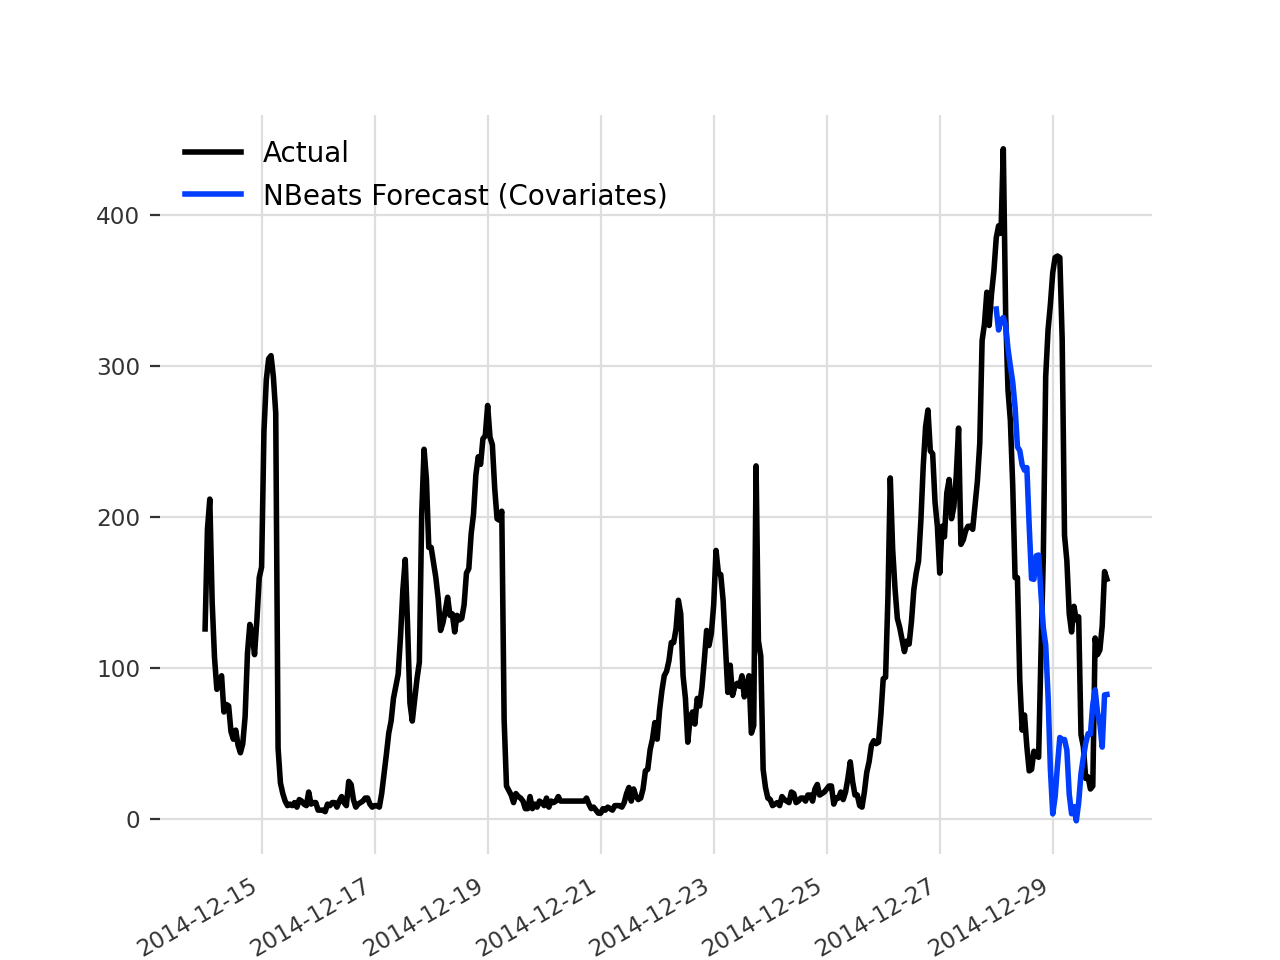

In [102]:
# Predict only For Validation

valid_pred = model.predict(series=scaled_train_ts[train_start_index:],
                           past_covariates=scaled_train_covs[train_start_index:],
                           n=48) 

valid_pred = scaler_target.inverse_transform(valid_pred)
``
plot_start_index = len(train_data) - 24*14
staging_train[plot_start_index:]['pm2.5'].plot(label='Actual')
valid_pred.plot(label='NBeats Forecast (Covariates)')

mape_ = mape(valid_data['pm2.5'], valid_pred)
print(f'MAPE: {round(mape_, 2)}%')

rmse_ = rmse(valid_data['pm2.5'], valid_pred)
print(f'RMSE: {round(rmse_, 2)}%')